###CARREGAMENTO DO DATASET DE TREINO E TESTE

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/
dir = ".//Dataset/"
test_dir = ".//Tests/"

/content/drive/MyDrive


In [ ]:
#DATASET AND PREPROCESSING
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
Width = 96
Height = 96
Image_Size = (Width, Height)
Channels = 1
Input_Shape = (Width, Height, Channels)
Batch_Size = 1

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    data_format = 'channels_last',
    dtype = np.float32,
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = Image_Size,
    batch_size = Batch_Size,
    color_mode = 'grayscale',
    class_mode = 'binary',
    subset = 'training',
)

Found 200 images belonging to 2 classes.


In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    zoom_range = (.95, .95),
    horizontal_flip = True,
    vertical_flip = False,
    data_format = 'channels_last',
    validation_split = 0.2,
    dtype = np.float32,
)

In [ ]:
train_gen = datagen.flow_from_directory(
    dir,
    target_size = Image_Size,
    batch_size = Batch_Size,
    color_mode = 'grayscale',
    class_mode = 'binary',
    shuffle = True,
    subset = 'training',
    seed = 23,
)

val_gen = datagen.flow_from_directory(
    dir,
    target_size = Image_Size,
    batch_size = Batch_Size,
    color_mode = 'grayscale',
    class_mode = 'binary',
    shuffle = True,
    subset = 'validation',
    seed = 23,
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
def visualization(datagen):
  classes = ['Helmet', 'NoHelmet']
  plt.figure(figsize=(16, 16), facecolor = 'silver')
  for i in range(9):
    images, labels = datagen.next()
    #BATCH_SIZE = 20
    ax = plt.subplot(3, 3, i + 1)
    #print(images[i])
    plt.imshow(images[0], cmap='gray')
    plt.title(classes[int(labels[0] > 0.5)])
    #print(labels[i])

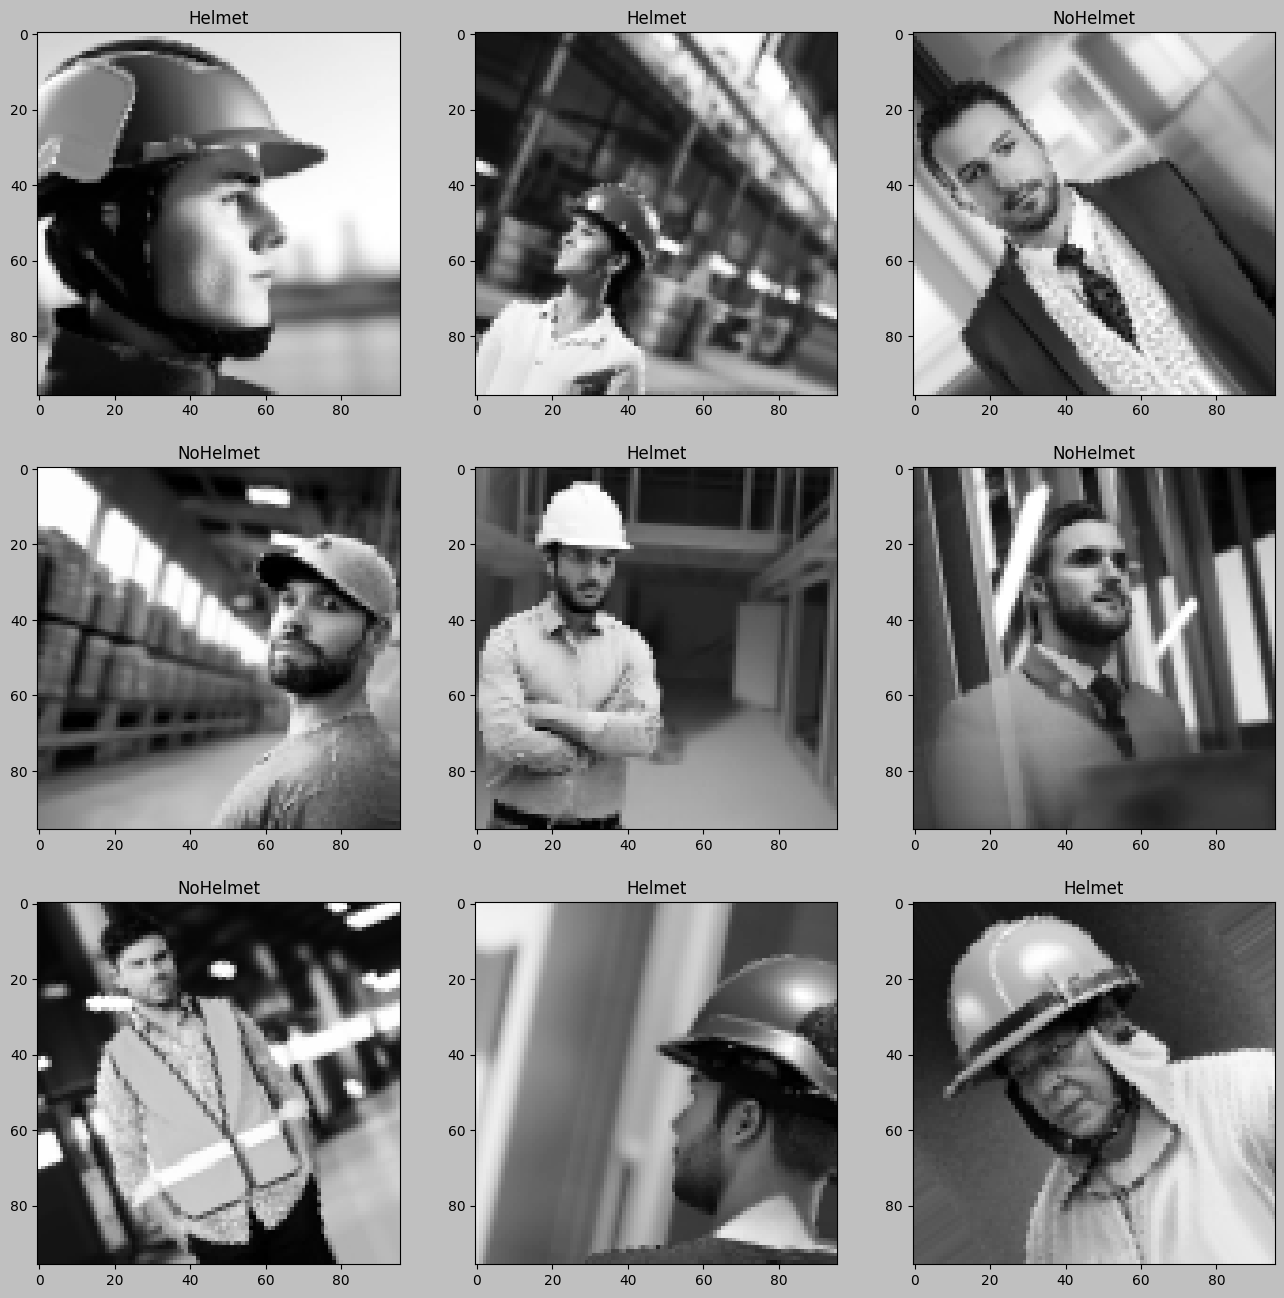

In [ ]:
visualization(train_gen)

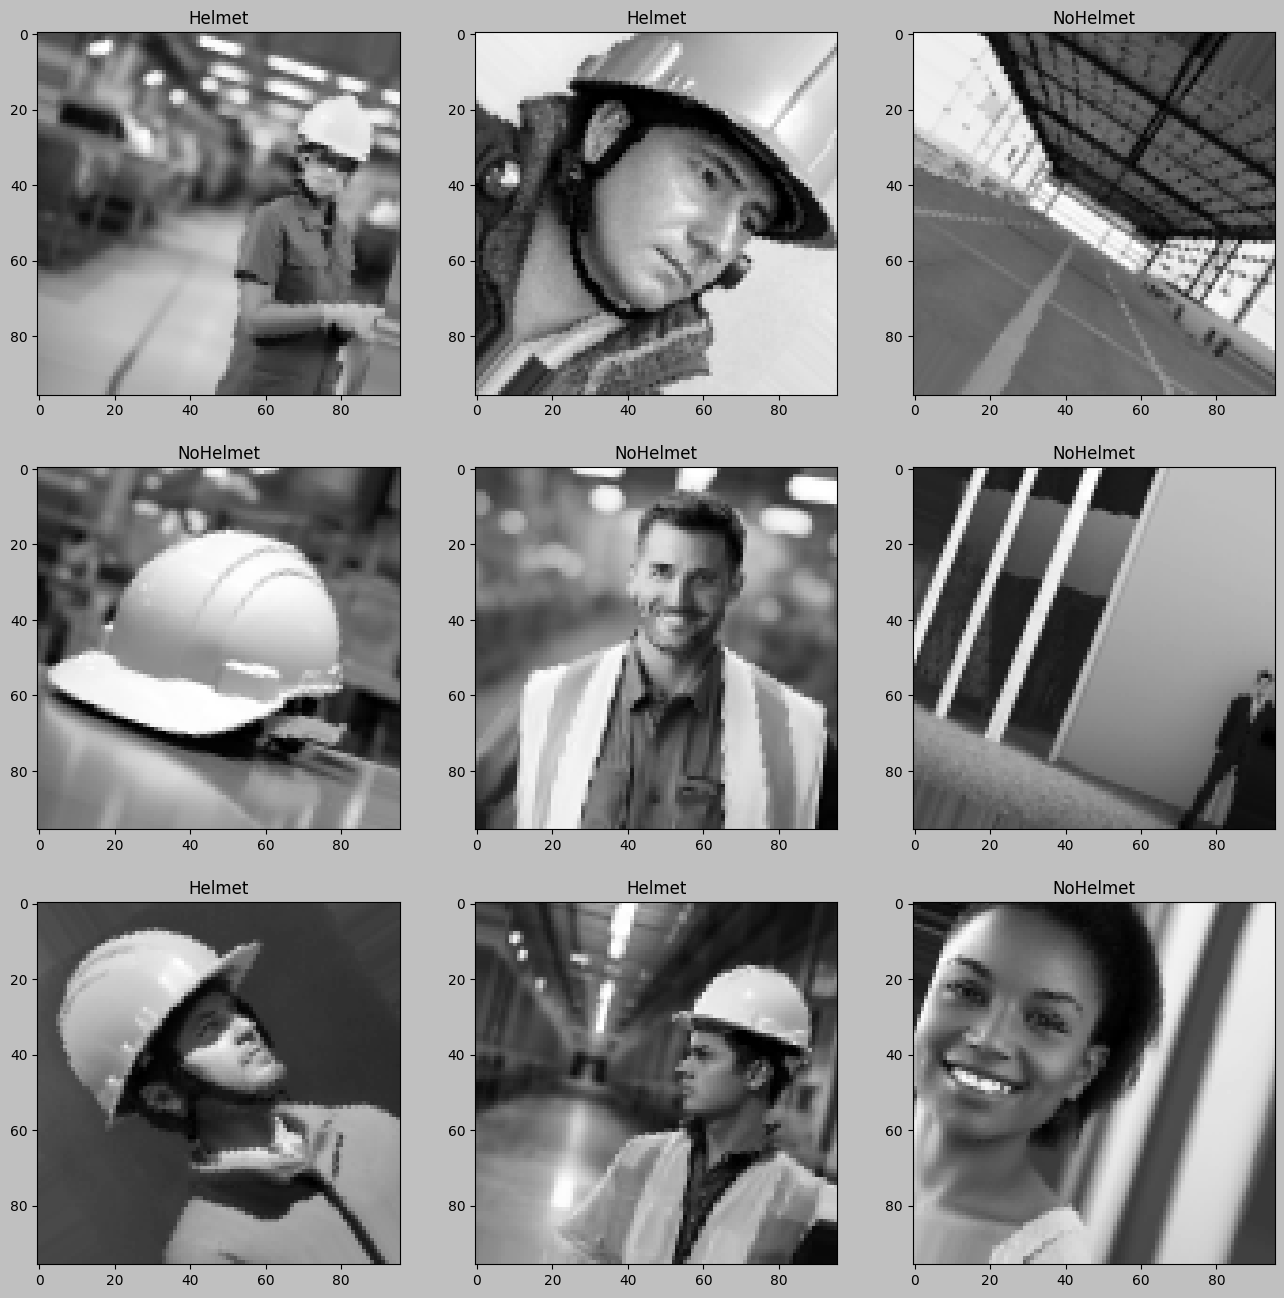

In [ ]:
visualization(val_gen)

###CRIAÇÃO DO MODELO

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
LEARNING_RATE = 0.0005

In [ ]:
#MODEL

callbacks = []

# model architecture
model = Sequential([
  layers.Input(Input_Shape, Batch_Size),
  layers.Conv2D(16, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
  layers.Conv2D(32, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
  layers.Conv2D(64, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
  layers.Conv2D(128, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
  layers.Flatten(),
  layers.Dropout(.5),
  layers.Dense(1, name='y_pred', activation='sigmoid')
])

# this controls the learning rate
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
print('Using early stopping...')
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

# train the neural network
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Using early stopping...


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1, 96, 96, 16)           160       
                                                                 
 max_pooling2d_4 (MaxPooling  (1, 48, 48, 16)          0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (1, 48, 48, 32)           4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (1, 24, 24, 32)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (1, 24, 24, 64)           18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (1, 12, 12, 64)         

In [ ]:
EPOCHS = 100

In [ ]:
history = model.fit(train_gen, epochs = EPOCHS, validation_data = val_gen, verbose=1, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False

Epoch 1/100
3200/3200 [==============================] - 60s 18ms/step - loss: 0.6188 - accuracy: 0.6628 - val_loss: 0.5325 - val_accuracy: 0.7225
Epoch 2/100
3200/3200 [==============================] - 54s 17ms/step - loss: 0.5424 - accuracy: 0.7306 - val_loss: 0.5096 - val_accuracy: 0.7725
Epoch 3/100
3200/3200 [==============================] - 53s 16ms/step - loss: 0.5149 - accuracy: 0.7547 - val_loss: 0.4714 - val_accuracy: 0.7812
Epoch 4/100
3200/3200 [==============================] - 52s 16ms/step - loss: 0.4734 - accuracy: 0.7794 - val_loss: 0.4513 - val_accuracy: 0.7912
Epoch 5/100
3200/3200 [==============================] - 54s 17ms/step - loss: 0.4471 - accuracy: 0.7931 - val_loss: 0.4221 - val_accuracy: 0.8062
Epoch 6/100
3200/3200 [==============================] - 54s 17ms/step - loss: 0.4407 - accuracy: 0.8034 - val_loss: 0.4143 - val_accuracy: 0.8125
Epoch 7/100
3200/3200 [==============================] - 53s 16ms/step - loss: 0.4259 - accuracy: 0.8081 - val_loss: 0

###VISUALIZAÇÃO HISTÓRICO TREINAMENTO

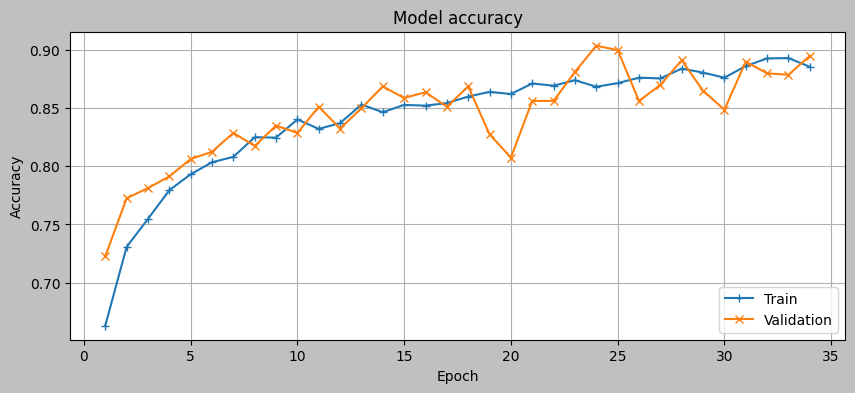

In [ ]:
def model_accu(history):
  x = np.array(range(1, len(history.history['accuracy']) + 1))
  plt.figure(figsize = (10,4), facecolor="silver")
  plt.plot(x, history.history['accuracy'], marker = "+")
  plt.plot(x, history.history['val_accuracy'], marker = "x")
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.grid()
  plt.show()

model_accu(history)

In [ ]:
print(history.history['accuracy'])

[0.6628124713897705, 0.7306249737739563, 0.754687488079071, 0.7793750166893005, 0.7931249737739563, 0.8034374713897705, 0.8081250190734863, 0.824999988079071, 0.8246874809265137, 0.8403124809265137, 0.8321874737739563, 0.8371875286102295, 0.8531249761581421, 0.8465625047683716, 0.8528125286102295, 0.8521875143051147, 0.8543750047683716, 0.8600000143051147, 0.864062488079071, 0.8621875047683716, 0.8712499737739563, 0.8693749904632568, 0.8740624785423279, 0.8684375286102295, 0.8715624809265137, 0.8762500286102295, 0.8756250143051147, 0.8840625286102295, 0.8806250095367432, 0.8762500286102295, 0.8862500190734863, 0.8928124904632568, 0.8931249976158142, 0.8856250047683716]


In [ ]:
print(history.history['val_accuracy'])

[0.7225000262260437, 0.7724999785423279, 0.78125, 0.7912499904632568, 0.8062499761581421, 0.8125, 0.8287500143051147, 0.8174999952316284, 0.8349999785423279, 0.8287500143051147, 0.8512499928474426, 0.8324999809265137, 0.8500000238418579, 0.8687499761581421, 0.8587499856948853, 0.8637499809265137, 0.8512499928474426, 0.8687499761581421, 0.8274999856948853, 0.8075000047683716, 0.856249988079071, 0.856249988079071, 0.8812500238418579, 0.9037500023841858, 0.8999999761581421, 0.856249988079071, 0.8700000047683716, 0.8912500143051147, 0.8650000095367432, 0.8487499952316284, 0.8899999856948853, 0.8799999952316284, 0.8787500262260437, 0.8949999809265137]


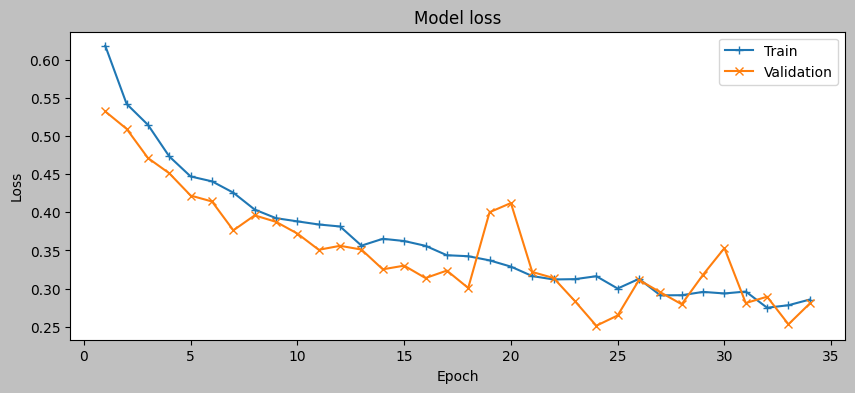

In [ ]:
def model_loss(history):
  x = np.array(range(1, len(history.history['loss']) + 1))
  plt.figure(figsize = (10,4), facecolor="silver")
  plt.plot(x, history.history['loss'], marker = "+")
  plt.plot(x, history.history['val_loss'], marker = "x")
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

model_loss(history)

In [ ]:
print(history.history['loss'])

[0.6187514066696167, 0.5424121022224426, 0.5149069428443909, 0.47339168190956116, 0.44713863730430603, 0.4407411813735962, 0.425851970911026, 0.403654545545578, 0.3924020528793335, 0.38821449875831604, 0.38411399722099304, 0.3814809322357178, 0.3563569188117981, 0.3653424084186554, 0.3624250292778015, 0.35609397292137146, 0.3437747061252594, 0.34247025847435, 0.3370321989059448, 0.3288029730319977, 0.3164014518260956, 0.3119561970233917, 0.31236550211906433, 0.31622159481048584, 0.3000563681125641, 0.31277066469192505, 0.2911337912082672, 0.2912789285182953, 0.29564881324768066, 0.2935834527015686, 0.29610514640808105, 0.27485451102256775, 0.2781482934951782, 0.28562378883361816]


In [ ]:
print(history.history['val_loss'])

[0.5324997901916504, 0.5096290111541748, 0.47135674953460693, 0.4512735605239868, 0.4220847189426422, 0.41429996490478516, 0.37643110752105713, 0.39611220359802246, 0.3875645101070404, 0.3721814453601837, 0.35088908672332764, 0.35614779591560364, 0.35116955637931824, 0.325283408164978, 0.3300812244415283, 0.31380602717399597, 0.3236074447631836, 0.3007911145687103, 0.40019118785858154, 0.412271112203598, 0.3217739164829254, 0.31383612751960754, 0.28345751762390137, 0.25123921036720276, 0.26469483971595764, 0.3112928867340088, 0.29516997933387756, 0.2794051170349121, 0.31817102432250977, 0.3530948758125305, 0.2810021936893463, 0.28930094838142395, 0.2531096935272217, 0.28044185042381287]


###TESTANDO O MODELO

In [ ]:
test_gen.class_indices

{'Helmet': 0, 'NoHelmet': 1}

In [ ]:
model.evaluate(test_gen, verbose = 2)

200/200 - 121s - loss: 0.1752 - accuracy: 0.9350 - 121s/epoch - 604ms/step


[0.17520612478256226, 0.9350000023841858]

In [ ]:
model.save('modelgray96-b1')

### Conversão TFLITE e TFLITE Micro

In [ ]:
!apt-get update && apt-get -qq install xxd

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,270 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,345 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease


In [ ]:
import math
import os

from absl import app
from absl import flags
from absl import logging
import numpy as np

In [ ]:
import glob

In [ ]:
image_folder = ".//Tests/NoHelmet"
img_path = glob.glob(image_folder+"/*")
if len(img_path)==0:
    print("image not found")
else:
  print(len(img_path))

100


In [ ]:
validation_data_set=[]
for file_name in img_path:
    img = cv.imread(file_name,0) #BGR
    img = cv.resize(img,(96, 96))
    #img = img[:,:,::-1]
    ary = np.asarray(img, dtype=np.float32)
    ary = np.expand_dims(ary, axis=0)
    ary = np.expand_dims(ary, axis=3)
    validation_data_set.append(ary)

In [ ]:
def representative_dataset_gen():
  for i in range(len(validation_data_set)):
    yield [validation_data_set[i]]

In [ ]:
def convert_tflite_model(model):
  """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format
    Args:
        model (tf.keras.Model): the trained hello_world Model
    Returns:
        The converted model in serialized format.
  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  return tflite_model

def convert_tflite_model_quant(model):
  """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format
    Args:
        model (tf.keras.Model): the trained hello_world Model
    Returns:
        The converted model in serialized format.
  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.int8  # or tf.uint8
  converter.inference_output_type = tf.int8  # or tf.uint8
  tflite_model = converter.convert()
  return tflite_model

In [ ]:
def save_tflite_model(tflite_model, save_dir, model_name):
  """save the converted tflite model
  Args:
      tflite_model (binary): the converted model in serialized format.
      save_dir (str): the save directory
      model_name (str): model name to be saved
  """
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  save_path = os.path.join(save_dir, model_name)
  with open(save_path, "wb") as f:
    f.write(tflite_model)
  logging.info("Tflite model saved to %s", save_dir)


In [ ]:
model32 = tf.keras.models.load_model('modelgray96-b1')

In [ ]:
# Convert and save the quantizated model to .tflite
tflite_model = convert_tflite_model_quant(model32)
save_tflite_model(tflite_model,
                  ".",
                  model_name="safe_helm-b1.tflite")

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
MODEL_TFLITE = 'safe_helm-b1.tflite'
MODEL_TFLITE_MICRO = 'safe_helm-b1.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}